# Code for making predictions with and without news features

## Libraries/Data required

In [7]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score


# Import models
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

data_dir = "data/" # Define data path

In [8]:
df = pd.read_csv(data_dir + "food_crises_cleaned.csv") # Read data into DataFrame
df["date"] = pd.to_datetime(df["year_month"], format="%Y_%m") # Create date column
print(len(df['district'].unique()))
df.set_index(["date", "district"], inplace=True) # Set index

78


## Basic visualizations

<br>
A bar chart showing the frequency of the different "fews_ipc" phases.

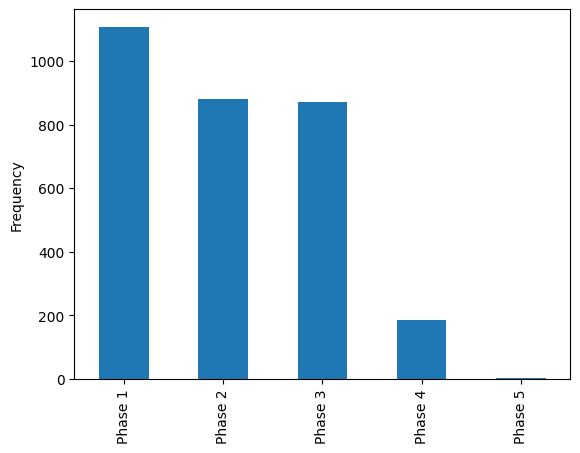

In [186]:
ax = df["ipc"].value_counts().plot(kind="bar") # Initialize barplot of fews_ipc counts
ax.set_xticklabels(["Phase {}".format(i) for i in range(1, 6)]) # Label the phases
ax.set_ylabel('Frequency'); # Set y label

<br>
A map of South Sudan showing the mean IPC per county (with geopandas).

C:\Users\20211445\AppData\Local\Temp\ipykernel_2568\480331542.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")) # Get map of the world


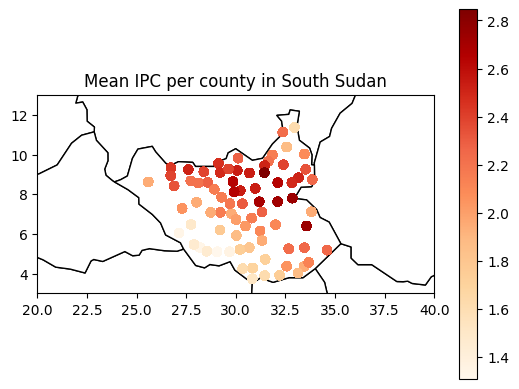

In [16]:
# Plot map of south sudan
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")) # Get map of the world

ax = world.plot(color="white", edgecolor="black") # Plot world map

# Bound map to south sudan
ax.set_xlim(20, 40)
ax.set_ylim(3, 13)

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["centx"], df["centy"])) # Initialize GeoDataFrame

# Calculate mean ipc per administration
mean_ipc = (
    df.reset_index()[["ipc", "district"]]
    .groupby("district")
    .mean()
    .rename(columns={"ipc": "mean_ipc"})
)

# Plot mean ipc per administration on map
gdf.merge(mean_ipc, on="district").plot(
    column="mean_ipc", ax=ax, legend=True, cmap="OrRd"
)

# Set plot title
ax.set_title("Mean IPC per county in South Sudan");

<BR>

## Helper Functions

Here we define a function that lags input variables. There are options for creating a rolling mean, taking the difference between subsequent rows, and dropping NaNs. Feature engineering can of course be extended much further than this.

In [9]:
def create_lag_df(df, columns, lag, difference=False, rolling=None, dropna=False):
    '''
    Function to add lagged colums to dataframe
    
    Inputs:
        df - Dataframe
        columns - List of columns to create lags from
        lag - The number of timesteps (in months for the default data) to lag the variable by
        difference - Whether to take the difference between each observation as new column
        rolling - The size of the rolling mean window, input None type to not use a rolling variable
        dropna - Whether to drop NaN values
        
    Output:
        df - Dataframe with the lagged columns added
    '''
    
    for column in columns:
        col = df[column].unstack()
        if rolling:
            col = col.rolling(rolling).mean()
        if difference:
            col = col.diff()
        if dropna:
            col = col.dropna(how='any')
        df[f"{column}_lag_{lag}"] = col.shift(lag).stack()
    return df

<br>
Here we define a function that plots a confusion matrix given a prediction and the true values, it can be used both for binary and categorical variables.

In [17]:
def plot_ConfusionMatrix(prediction, true, binary=False):
    '''
    Function to plot a confusion matrix as a heatmap from a prediction and true values.
    
    Inputs:
        prediction - The predicted values
        true - the true values
        binary - whether the variable is binary or not
        
    Output:
        confusion_matrix - The calculated confusion matrix based on the prediction and true values.
        
        Also plots the confusion matrix as heatmap in an interactive environment such as Jupyter Notebook.
    '''
    
    y_pred = prediction
    
    if not binary:
        # Round prediction to nearest integer (i.e. the nearest phase)
        y_pred = y_pred.round() 
        y_pred = np.minimum(y_pred, 5) # Cap maximum prediction at 5 (maximum phase)
        y_pred = np.maximum(y_pred, 1) # Cap minimum prediction at 1 (minimum phase)

    # Initialize confusion matrix
    confusion_matrix = pd.crosstab(
        true, y_pred, rownames=["Actual"], colnames=["Predicted"]
    )

    # Plot confusion matrix as heatmap
    sns.heatmap(confusion_matrix, annot=True, fmt="g")
    plt.show()
    plt.clf()
    
    return confusion_matrix

## Making Predictions

To simplify, we treat the IPC prediction problem as regression rather than classification,
e.g., multivariable logistic regression might be more suited.
<br><br>
We use a TimeSeriesSplit to divide the data into 5 training-test splits and run cross-validation on these splits. 
<br>We report the confusion matrix (with training and test split as title) along with the model summary per split; the mean MAE and mean R2 are reported after completion of cross-validation.
<br><br>
First however, we create multiple lagged variables in the cell directly below.

In [10]:
# Create several lagged columns to use as explanatory variables for the model

df = create_lag_df(df, ['count_violence', 'ndvi_anom'], 3, rolling=6) # 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['food_price_idx'], 3, difference=True, rolling=6) # difference of the 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['ipc'], 1, dropna=True) # 1-month-lag
df = create_lag_df(df, ['ipc'], 2, dropna=True) # 2-month-lag
df = create_lag_df(df, ['ipc'], 3, dropna=True) # 3-month-lag

df.columns # View the newly created columns

Index(['country', 'district_code', 'centx', 'centy', 'year_month', 'year',
       'month', 'ipc', 'ha', 'ndvi_mean', 'ndvi_anom', 'rain_mean',
       'rain_anom', 'et_mean', 'et_anom', 'count_violence', 'sum_fatalities',
       'food_price_idx', 'area', 'cropland_pct', 'pop', 'ruggedness_mean',
       'pasture_pct', 'count_violence_lag_3', 'ndvi_anom_lag_3',
       'food_price_idx_lag_3', 'ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3'],
      dtype='object')

In [11]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column

In [192]:
df

country  district_code     centx     centy  \
date       district                                                       
2009-07-01 Abiemnhom     South Sudan            136  29.13019  9.550939   
           Akobo         South Sudan            114  32.85308  7.799214   
           Anzara        South Sudan             86  28.20598  5.309739   
           Aweil Center  South Sudan            128  26.89562  8.417934   
           Aweil East    South Sudan            141  27.61364  9.243139   
...                              ...            ...       ...       ...   
2020-02-01 Wulu          South Sudan            105  29.20889  6.200243   
           Yambio        South Sudan             82  28.54729  5.124909   
           Yei           South Sudan             81  30.34454  4.252148   
           Yirol East    South Sudan            107  30.80245  6.793194   
           Yirol West    South Sudan            101  30.48698  6.395244   

                        year_month  year  month  ipc   ha  ndvi_mean  ...  \
date       district                                                   ...   
2009-07-01 Abiemnhom       2009_07  2009      7  2.0  NaN   0.698165  ...   
           Akobo           2009_07  2009      7  4.0  NaN   0.474723  ...   
           Anzara          2009_07  2009      7  1.0  NaN   0.812001  ...   
           Aweil Center    2009_07  2009      7  2.0  NaN   0.723154  ...   
           Aweil East      2009_07  2009      7  3.0  NaN   0.547611  ...   
...                            ...   ...    ...  ...  ...        ...  ...   
2020-02-01 Wulu            2020_02  2020      2  2.0  0.0   0.374735  ...   
           Yambio          2020_02  2020      2  3.0  0.0   0.468085  ...   
           Yei             2020_02  2020      2  3.0  0.0   0.452878  ...   
           Yirol East      2020_02  2020      2  4.0  0.0   0.410408  ...   
           Yirol West      2020_02  2020      2  3.0  0.0   0.319411  ...   

                         cropland_pct        pop  ruggedness_mean  \
date       district                                                 
2009-07-01 Abiemnhom         1.742261   20702.00        11004.640   
           Akobo            10.046920  158222.00         2787.772   
           Anzara           18.819290   76442.00        51381.880   
           Aweil Center      0.173833   48376.00         3754.860   
           Aweil East       26.804220  345977.00         3544.279   
...                               ...        ...              ...   
2020-02-01 Wulu              0.032678   45158.50        40366.550   
           Yambio           19.126490  197278.90        60628.160   
           Yei              16.303490  288875.40        75813.310   
           Yirol East        2.482445   73693.13        18421.020   
           Yirol West        0.462767  111980.60        25073.430   

                         pasture_pct  count_violence_lag_3  ndvi_anom_lag_3  \
date       district                                                           
2009-07-01 Abiemnhom        91.48276              0.000000        95.891380   
           Akobo            89.71963              0.333333       111.870073   
           Anzara           58.21333              0.000000       103.035443   
           Aweil Center     81.76336              0.000000       106.495113   
           Aweil East       90.16216              0.000000       102.086478   
...                              ...                   ...              ...   
2020-02-01 Wulu             65.10490              0.000000       103.909292   
           Yambio           60.88350              0.500000       101.517510   
           Yei              62.85185              2.333333       102.151617   
           Yirol East       91.75000              0.166667       103.811285   
           Yirol West       87.71930              0.833333       102.977952   

                         food_price_idx_lag_3  ipc_lag_1  ipc_lag_2  ipc_lag_3  
date       district                         

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     258.4
Date:                Thu, 28 Sep 2023   Prob (F-statistic):          4.40e-196
Time:                        17:31:23   Log-Likelihood:                -298.28
No. Observations:                 962   AIC:                             610.6
Df Residuals:                     955   BIC:                             644.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.8493 

NameError: name 'plot_ConfusionMatrix' is not defined

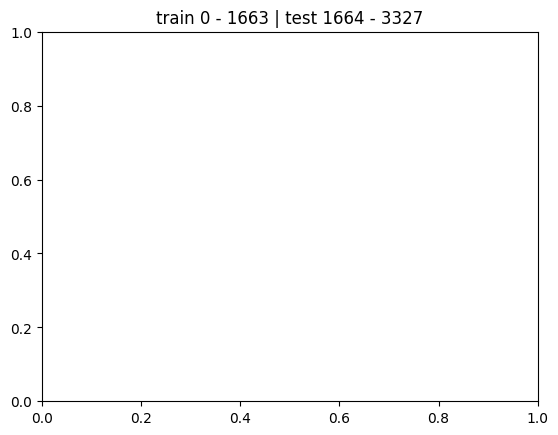

In [12]:
X = df.iloc[:, -6:] # Define explanatory variables
X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df[["ipc"]] # Define target data

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# Initinalize empty lists to score scores
mae_values = list()
r2_values = list()

for train_index, val_index in cv.split(X): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)

    model = OLS(y_train, X_train, missing="drop") # Initialize OLS model on training data
    results = model.fit() # Get model results on training data
    print(results.summary()) # Print model summary

    y_pred = results.predict(X_test) # Run model on test data
    
    # Append results to respective lists
    mae_values.append((y_pred - y_val['ipc']).abs().mean())
    r2_values.append(results.rsquared)
    
    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']) # Plot confusion matrix
    
print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE
print(f"Mean R2: {np.mean(r2_values):.2f}") # Print R2

## Incorporating News Features

We look at country wide news features to simplify. E.g., we do not look at topics per district

In [6]:
news_df = pd.read_csv(data_dir + "articles_topics.csv") # Read news data into DataFrame

# Create date column
news_df["date"] = pd.to_datetime(
    pd.to_datetime(news_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)
news_df

,summary,date,location_article,lat,lng,hunger,refugees,humanitarian,conflict
0,The article discusses the passing of the new C...,2011-07-01,Juba,4.859363,31.571250,False,False,False,False
1,The article discusses the military actions tak...,2011-07-01,Abyei,9.838551,28.486396,False,False,False,False
2,The article discusses the signing of a Framewo...,2011-06-01,Southern Kordofan,11.036544,30.895824,False,False,False,False
3,The article discusses the upcoming independenc...,2011-07-01,South Sudan,6.876992,31.306979,False,False,False,False
4,The article discusses the need for South Sudan...,2011-07-01,Juba,4.859363,31.571250,False,False,False,False
...,...,...,...,...,...,...,...,...,...
18515,The article discusses the successful delivery ...,2023-04-01,Maiwut Primary Health Care Centre,8.606200,33.924100,False,False,False,False
18516,The article discusses the bombing and forced e...,2023-04-01,Khartoum,15.500654,32.559899,False,False,False,False
18517,The article discusses how Prime Minister Abiy ...,2023-04-01,Addis Ababa,8.980603,38.757761,False,False,False,False
18518,The article discusses the collapse of a commer...,2023-04-01,Kampala International University,0.294360,32.603970,False,False,False,False


In [205]:
def create_news_features(columns):
    cols = []
    for column in columns:
        col = news_df.groupby(["date"])[column].mean()
        col = col.fillna(0)
        col = col.rolling(3).mean()
        col = col.shift(3)
        cols.append(col)
    return pd.concat(cols, axis=1)



### Visualization of news features over time

The 2017 South Sudan famine is very apparent. Most of this event needs to be predicted out-of-sample with the training/test split we chose.

More info on the famine : https://en.wikipedia.org/wiki/2017_South_Sudan_famine

In [206]:
# country wide news features
news_features = create_news_features(["hunger", 'refugees', 'conflict', 'humanitarian'])
news_features

#news_features.plot();

,hunger,refugees,conflict,humanitarian
date,,,,
2011-06-01,NaN,NaN,NaN,NaN
2011-07-01,NaN,NaN,NaN,NaN
2011-08-01,NaN,NaN,NaN,NaN
2011-09-01,NaN,NaN,NaN,NaN
2011-10-01,NaN,NaN,NaN,NaN
...,...,...,...,...
2022-12-01,4.625929e-18,0.000000,0.0,0.050000
2023-01-01,4.625929e-18,0.000000,0.0,0.050000
2023-02-01,8.333333e-02,0.000000,0.0,0.069444


In [ ]:
# Get the mean share of articles per ipc for the different topics
combined = (
    pd.DataFrame(y['ipc'])
    .join(news_df.groupby(["date"])["hunger"].mean())
    .join(news_df.groupby(["date"])["refugees"].mean())
    .join(news_df.groupby(["date"])["conflict"].mean())
    .join(news_df.groupby(["date"])["humanitarian"].mean())
)


# Plot the mean share of articles per ipc value for the different topics
combined.groupby("ipc")[["hunger", "refugees", "conflict", "humanitarian"]].mean().plot(
    kind="bar", ylabel="Share of total articles"
);

## Predicting using news features

In [207]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column
df = df.join(news_features, how="left") # Join df with created news features

In [218]:
df.iloc[:, -15:]

area  cropland_pct        pop  ruggedness_mean  \
date       district                                                            
2009-07-01 Abiemnhom      2408.233      1.742261   20702.00        11004.640   
           Akobo          9027.626     10.046920  158222.00         2787.772   
           Anzara         6541.319     18.819290   76442.00        51381.880   
           Aweil Center  11202.960      0.173833   48376.00         3754.860   
           Aweil East     6400.981     26.804220  345977.00         3544.279   
...                            ...           ...        ...              ...   
2020-02-01 Wulu          11894.780      0.032678   45158.50        40366.550   
           Yambio         8896.165     19.126490  197278.90        60628.160   
           Yei            6713.251     16.303490  288875.40        75813.310   
           Yirol East     5599.893      2.482445   73693.13        18421.020   
           Yirol West     4879.717      0.462767  111980.60        25073.430   

                         pasture_pct  count_violence_lag_3  ndvi_anom_lag_3  \
date       district                                                           
2009-07-01 Abiemnhom        91.48276              0.000000        95.891380   
           Akobo            89.71963              0.333333       111.870073   
           Anzara           58.21333              0.000000       103.035443   
           Aweil Center     81.76336              0.000000       106.495113   
           Aweil East       90.16216              0.000000       102.086478   
...                              ...                   ...              ...   
2020-02-01 Wulu             65.10490              0.000000       103.909292   
           Yambio           60.88350              0.500000       101.517510   
           Yei              62.85185              2.333333       102.151617   
           Yirol East       91.75000              0.166667       103.811285   
           Yirol West       87.71930              0.833333       102.977952   

                         food_price_idx_lag_3  ipc_lag_1  ipc_lag_2  \
date       district                                                   
2009-07-01 Abiemnhom                 0.007091        NaN        NaN   
           Akobo                     0.005769        NaN        NaN   
           Anzara                    0.005331        NaN        NaN   
           Aweil Center              0.023279        NaN        NaN   
           Aweil East                0.013091        NaN        NaN   
...                                       ...        ...        ...   
2020-02-01 Wulu                      2.463037        2.0        3.0   
           Yambio                    2.371327        2.0        3.0   
           Yei                       3.138777        3.0        3.0   
           Yirol East                3.468092        3.0        4.0   
           Yirol West                3.407927        3.0        4.0   

                         ipc_lag_3        hunger  refugees  conflict  \
date       district                                                    
2009-07-01 Abiemnhom           NaN           NaN       NaN       NaN   
           Akobo               NaN           NaN       NaN       NaN   
           Anzara              NaN           NaN       NaN       NaN   
           Aweil Center        NaN           NaN       NaN       NaN   
           Aweil East          NaN           NaN       NaN       NaN   
...                            ...           ...       ...       ...   
2020-02-01 Wulu                3.0  2.312965e-18       0.0       0.0   
           Yambio              3.0  2.312965e-18       0.0       0.0   
           Yei                 3.0  2.312965e-18       0.0       0.0   
           Yirol East          4.0  2.312965e-18       0.0       0.0   
           Yirol West          4.0  2.312965e-18       0.0       0.0   

                         humanitarian  
date       district                    
2009-07-01 Abiemnhom

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     258.4
Date:                Thu, 21 Sep 2023   Prob (F-statistic):          4.40e-196
Time:                        19:42:30   Log-Likelihood:                -298.28
No. Observations:                 962   AIC:                             610.6
Df Residuals:                     955   BIC:                             644.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.8493 

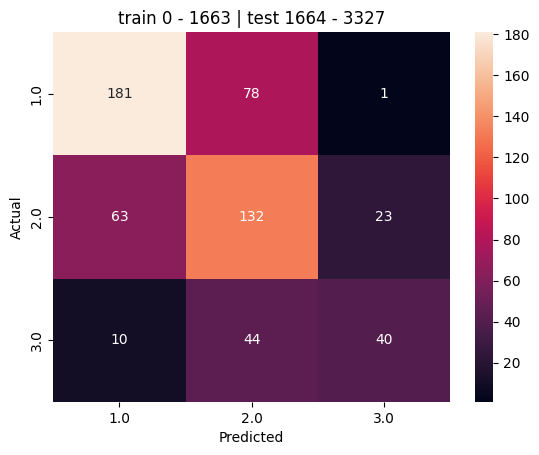

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     263.5
Date:                Thu, 21 Sep 2023   Prob (F-statistic):          2.26e-287
Time:                        19:42:30   Log-Likelihood:                -535.84
No. Observations:                1144   AIC:                             1094.
Df Residuals:                    1133   BIC:                             1149.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.8777 

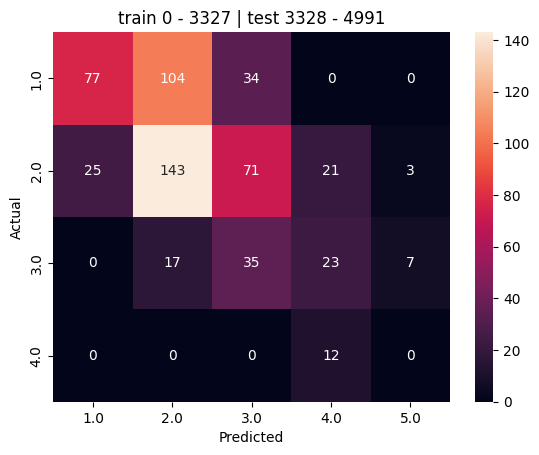

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     461.0
Date:                Thu, 21 Sep 2023   Prob (F-statistic):               0.00
Time:                        19:42:31   Log-Likelihood:                -1631.1
No. Observations:                2808   AIC:                             3284.
Df Residuals:                    2797   BIC:                             3350.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0578 

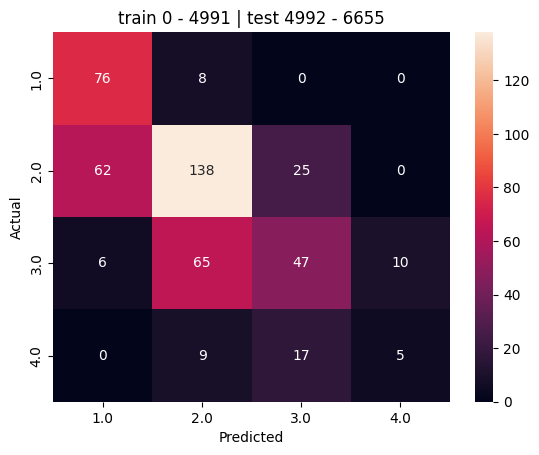

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     890.9
Date:                Thu, 21 Sep 2023   Prob (F-statistic):               0.00
Time:                        19:42:31   Log-Likelihood:                -2706.4
No. Observations:                4472   AIC:                             5435.
Df Residuals:                    4461   BIC:                             5505.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.3103 

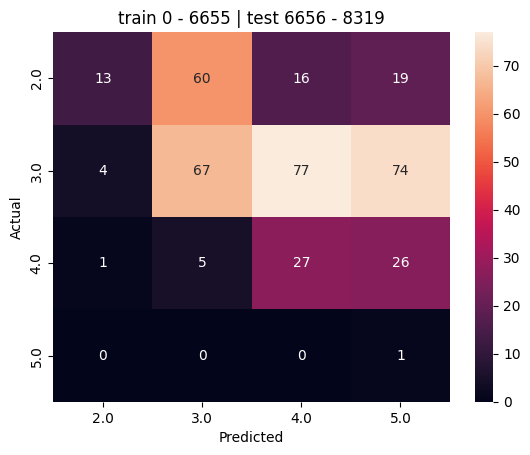

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     1440.
Date:                Thu, 21 Sep 2023   Prob (F-statistic):               0.00
Time:                        19:42:32   Log-Likelihood:                -3934.1
No. Observations:                6136   AIC:                             7890.
Df Residuals:                    6125   BIC:                             7964.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.3451 

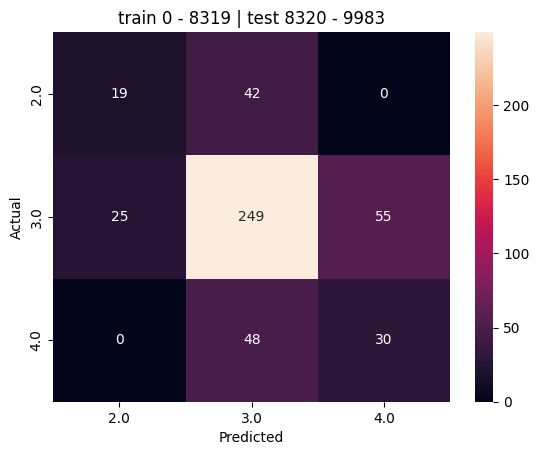

Mean MAE: 0.67
Mean R2: 0.66


<Figure size 640x480 with 0 Axes>

In [211]:
X = df.iloc[:, -10:] # Define explanatory variables
X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df[["ipc"]] # Define target data

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# Initinalize empty lists to score scores
mae_values = list()
r2_values = list()

for train_index, val_index in cv.split(X): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
    X_train = X_train.dropna(axis=1, how='all').copy()
    X_test = X_test[X_train.columns]
    
    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)

    model = OLS(y_train, X_train, missing="drop") # Initialize OLS model on training data
    results = model.fit() # Get model results on training data
    print(results.summary()) # Print model summary

    y_pred = results.predict(X_test) # Run model on test data
    
    # Append results to respective lists
    mae_values.append((y_pred - y_val['ipc']).abs().mean())
    r2_values.append(results.rsquared)

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']) # Plot confusion matrix
    
print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE
print(f"Mean R2: {np.mean(r2_values):.2f}") # Print R2

In [ ]:
X.columns

We see that the R2 has risen somewhat compared to the baseline.

### Predicting crisis/no crisis

We can also transform the IPC prediction in a binary classification problem by considering IPC 3+ as crisis, and IPC 2- as no-crisis. Let's give a simple example

In [18]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column

In [14]:
df.iloc[:,-10:].columns

Index(['cropland_pct', 'pop', 'ruggedness_mean', 'pasture_pct',
       'count_violence_lag_3', 'ndvi_anom_lag_3', 'food_price_idx_lag_3',
       'ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3'],
      dtype='object')

Optimization terminated successfully.
         Current function value: 0.023951
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                    ipc   No. Observations:                  962
Model:                          Logit   Df Residuals:                      958
Method:                           MLE   Df Model:                            3
Date:                Thu, 28 Sep 2023   Pseudo R-squ.:                  0.7213
Time:                        17:32:17   Log-Likelihood:                -23.041
converged:                       True   LL-Null:                       -82.676
Covariance Type:            nonrobust   LLR p-value:                 1.108e-25
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -16.9214      2.560     -6.610      0.000     -21.939     -11.904
ipc_lag_1      7.5452      1

NameError: name 'plot_ConfusionMatrix' is not defined

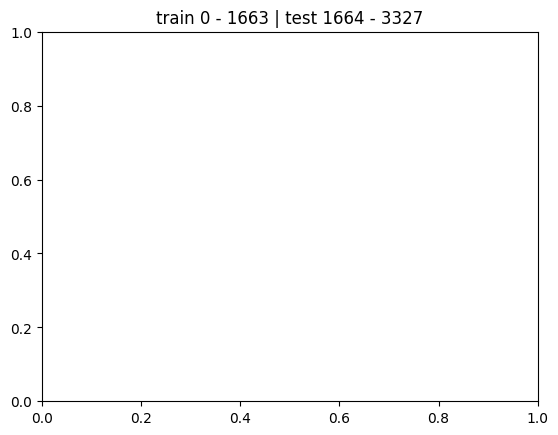

In [15]:
X = df.iloc[:, -10:] # Define explanatory variables
X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df[["ipc"]] # Define target data

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits
acc_values = list() # Initinalize empty lists to score accuracy scores

for train_index, val_index in cv.split(X): # Loop over the different training-test splits
    
    y_binary = y > 2 # Convert y to binary variable
    y_binary[y.isna()] = pd.NA # Conserve NaN values
    y_binary = y_binary.astype("float32") # Convert y to float

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y_binary.iloc[train_index], y_binary.iloc[val_index]
    
    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)
    
    cols = ['const', 'ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3'] # Select columns to use in model
    model = sm.Logit(y_train, X_train[cols], missing="drop") # Initialize Logit model
    results = model.fit() # Get model results on training data
    print(results.summary()) # Print model summary

    y_pred = results.predict(X_test[cols]) # Run model on test data

    # Convert prediction and validation to boolean
    y_pred = y_pred.round().astype(bool)
    y_val = y_val.round().astype(bool)

    # Drop all rows from prediction and validation where validation is null
    y_pred = y_pred[list(y_val.isnull()['ipc']==False)]
    y_val.dropna(inplace=True)

    acc_values.append(accuracy_score(y_val, y_pred)) # Append accuracy to list

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc'], binary = True) # Plot confusion matrix
    
print(f"Mean Acc: {np.mean(acc_values):.2f}") # Print Acc

### Moja zabawa z kategoriami

In [19]:
new_news_df.columns[5:]

NameError: name 'new_news_df' is not defined

In [20]:
new_news_df = pd.read_csv(data_dir + "articles_newtopics.csv") # Read news data into DataFrame

# Create date column
new_news_df["date"] = pd.to_datetime(
    pd.to_datetime(news_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)

In [21]:
def create_news_features(columns):
    cols = []
    for column in columns:
        col = new_news_df.groupby(["date"])[column].mean()
        col = col.fillna(0)
        col = col.rolling(3).mean()
        col = col.shift(3)
        cols.append(col)
    return pd.concat(cols, axis=1)


In [22]:
new_news_features = create_news_features(new_news_df.columns[5:])
new_news_features
#news_features.plot();

,hunger,conflict,humanitarian,refugees,politics,economics,production,land,pests,environment,covid
date,,,,,,,,,,,
2011-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01,0.022222,0.0,0.050000,0.000000,4.625929e-18,0.000000,0.055556,4.625929e-18,1.850372e-17,1.850372e-17,0.000000
2023-01-01,0.022222,0.0,0.050000,0.000000,5.555556e-02,0.000000,0.055556,4.625929e-18,1.850372e-17,5.555556e-02,0.000000
2023-02-01,0.083333,0.0,0.069444,0.000000,5.555556e-02,0.083333,0.138889,8.333333e-02,1.250000e-01,1.388889e-01,0.041667


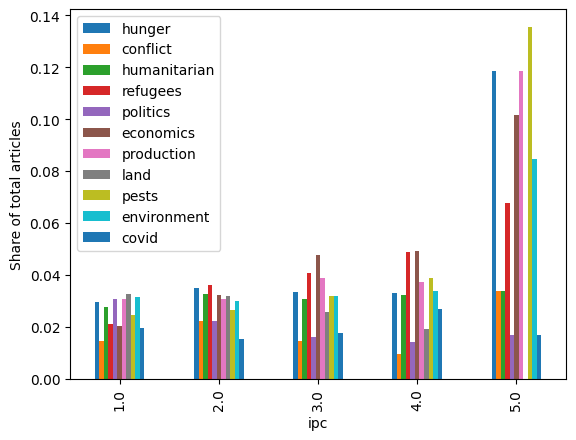

In [23]:
# Get the mean share of articles per ipc for the different topics
combined = (
    pd.DataFrame(y['ipc'])
    .join(new_news_df.groupby(["date"])["hunger"].mean())
    .join(new_news_df.groupby(["date"])["conflict"].mean())
    .join(new_news_df.groupby(["date"])["refugees"].mean())
    .join(new_news_df.groupby(["date"])["humanitarian"].mean())
    .join(new_news_df.groupby(["date"])["politics"].mean())
    .join(new_news_df.groupby(["date"])["economics"].mean())
    .join(new_news_df.groupby(["date"])["production"].mean())
    .join(new_news_df.groupby(["date"])["land"].mean())
    .join(new_news_df.groupby(["date"])["pests"].mean())
    .join(new_news_df.groupby(["date"])["environment"].mean())
    .join(new_news_df.groupby(["date"])["covid"].mean())
)


# Plot the mean share of articles per ipc value for the different topics
combined.groupby("ipc")[new_news_df.columns[5:]].mean().plot(
    kind="bar", ylabel="Share of total articles"
);

In [24]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column
df_new = df.join(new_news_features, how="left") # Join df with created news features
df_new

country  district_code     centx     centy  \
date       district                                                       
2009-07-01 Abiemnhom     South Sudan            136  29.13019  9.550939   
           Akobo         South Sudan            114  32.85308  7.799214   
           Anzara        South Sudan             86  28.20598  5.309739   
           Aweil Center  South Sudan            128  26.89562  8.417934   
           Aweil East    South Sudan            141  27.61364  9.243139   
...                              ...            ...       ...       ...   
2020-02-01 Wulu          South Sudan            105  29.20889  6.200243   
           Yambio        South Sudan             82  28.54729  5.124909   
           Yei           South Sudan             81  30.34454  4.252148   
           Yirol East    South Sudan            107  30.80245  6.793194   
           Yirol West    South Sudan            101  30.48698  6.395244   

                        year_month  year  month  ipc   ha  ndvi_mean  ...  \
date       district                                                   ...   
2009-07-01 Abiemnhom       2009_07  2009      7  2.0  NaN   0.698165  ...   
           Akobo           2009_07  2009      7  4.0  NaN   0.474723  ...   
           Anzara          2009_07  2009      7  1.0  NaN   0.812001  ...   
           Aweil Center    2009_07  2009      7  2.0  NaN   0.723154  ...   
           Aweil East      2009_07  2009      7  3.0  NaN   0.547611  ...   
...                            ...   ...    ...  ...  ...        ...  ...   
2020-02-01 Wulu            2020_02  2020      2  2.0  0.0   0.374735  ...   
           Yambio          2020_02  2020      2  3.0  0.0   0.468085  ...   
           Yei             2020_02  2020      2  3.0  0.0   0.452878  ...   
           Yirol East      2020_02  2020      2  4.0  0.0   0.410408  ...   
           Yirol West      2020_02  2020      2  3.0  0.0   0.319411  ...   

                         conflict  humanitarian  refugees      politics  \
date       district                                                       
2009-07-01 Abiemnhom          NaN           NaN       NaN           NaN   
           Akobo              NaN           NaN       NaN           NaN   
           Anzara             NaN           NaN       NaN           NaN   
           Aweil Center       NaN           NaN       NaN           NaN   
           Aweil East         NaN           NaN       NaN           NaN   
...                           ...           ...       ...           ...   
2020-02-01 Wulu          0.010753      0.022247       0.0  4.625929e-18   
           Yambio        0.010753      0.022247       0.0  4.625929e-18   
           Yei           0.010753      0.022247       0.0  4.625929e-18   
           Yirol East    0.010753      0.022247       0.0  4.625929e-18   
           Yirol West    0.010753      0.022247       0.0  4.625929e-18   

                         economics  production      land     pests  \
date       district                                                  
2009-07-01 Abiemnhom           NaN         NaN       NaN       NaN   
           Akobo               NaN         NaN       NaN       NaN   
           Anzara              NaN         NaN       NaN       NaN   
           Aweil Center        NaN         NaN       NaN       NaN   
           Aweil East          NaN         NaN       NaN       NaN   
...                            ...         ...       ...       ...   
2020-02-01 Wulu            0.05673    0.022052  0.032258  0.011494   
           Yambio          0.05673    0.022052  0.032258  0.011494   
           Yei             0.05673    0.022052  0.032258  0.011494   
           Yirol East      0.05673    0.022052  0.032258  0.011494   
           Yirol West      0.05673    0.022052  0.032258  0.011494   

                         environment     covid  
date       district                             
2009-07-01 Abiemnhom             NaN       NaN  
           Akobo 

In [30]:
df_new.iloc[:,-32:]
df_new.columns

Index(['country', 'district_code', 'centx', 'centy', 'year_month', 'year',
       'month', 'ipc', 'ha', 'ndvi_mean', 'ndvi_anom', 'rain_mean',
       'rain_anom', 'et_mean', 'et_anom', 'count_violence', 'sum_fatalities',
       'food_price_idx', 'area', 'cropland_pct', 'pop', 'ruggedness_mean',
       'pasture_pct', 'count_violence_lag_3', 'ndvi_anom_lag_3',
       'food_price_idx_lag_3', 'ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3', 'hunger',
       'conflict', 'humanitarian', 'refugees', 'politics', 'economics',
       'production', 'land', 'pests', 'environment', 'covid'],
      dtype='object')

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     91.09
Date:                Thu, 28 Sep 2023   Prob (F-statistic):          6.80e-204
Time:                        17:37:39   Log-Likelihood:                -244.12
No. Observations:                 962   AIC:                             530.2
Df Residuals:                     941   BIC:                             632.5
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.6762 

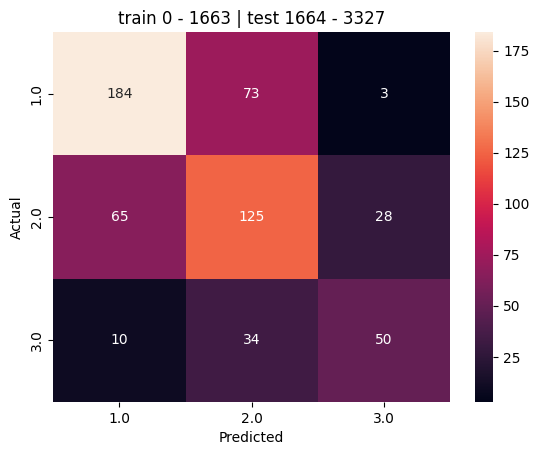

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     97.74
Date:                Thu, 28 Sep 2023   Prob (F-statistic):          7.27e-292
Time:                        17:37:39   Log-Likelihood:                -471.05
No. Observations:                1144   AIC:                             1006.
Df Residuals:                    1112   BIC:                             1167.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.2078 

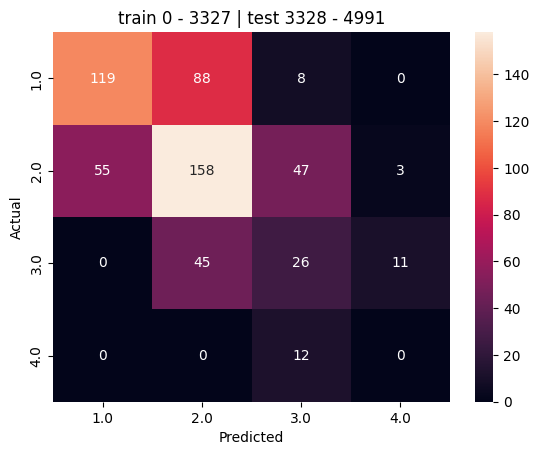

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     211.4
Date:                Thu, 28 Sep 2023   Prob (F-statistic):               0.00
Time:                        17:37:39   Log-Likelihood:                -1296.8
No. Observations:                2808   AIC:                             2658.
Df Residuals:                    2776   BIC:                             2848.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.2319 

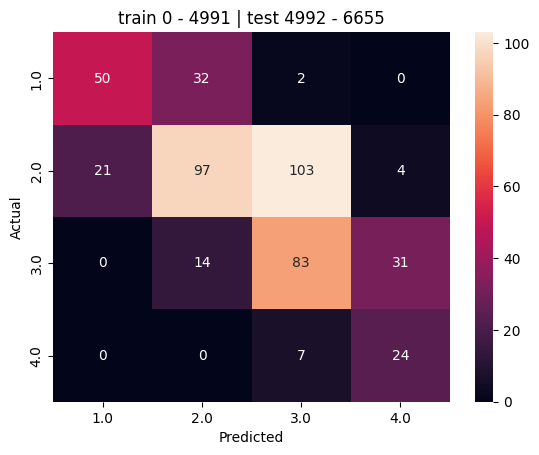

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     406.8
Date:                Thu, 28 Sep 2023   Prob (F-statistic):               0.00
Time:                        17:37:40   Log-Likelihood:                -2152.0
No. Observations:                4472   AIC:                             4368.
Df Residuals:                    4440   BIC:                             4573.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.7217 

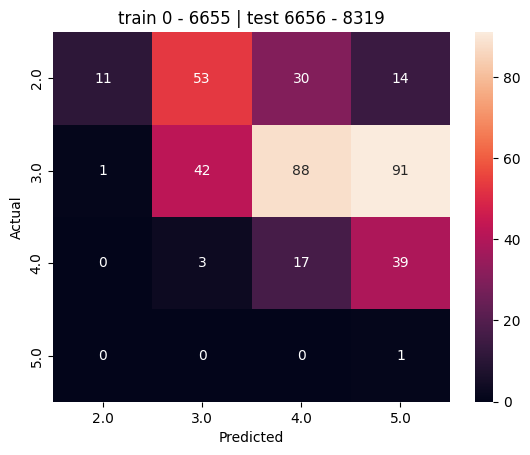

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     639.3
Date:                Thu, 28 Sep 2023   Prob (F-statistic):               0.00
Time:                        17:37:40   Log-Likelihood:                -3207.7
No. Observations:                6136   AIC:                             6479.
Df Residuals:                    6104   BIC:                             6695.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.6686 

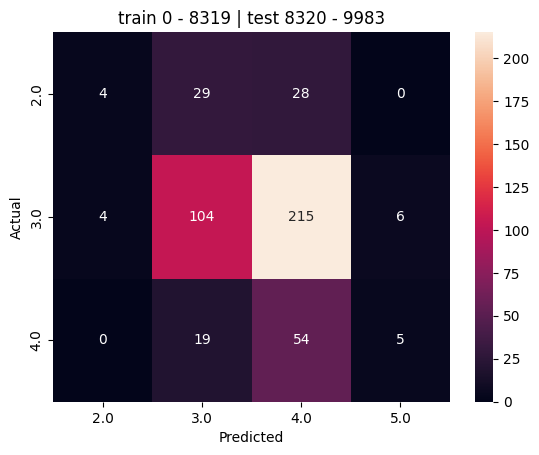

Mean MAE: 0.67
Mean R2: 0.72


<Figure size 640x480 with 0 Axes>

In [31]:
X = df_new.iloc[:, -31:] # Define explanatory variables
X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df_new[["ipc"]] # Define target data

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# Initinalize empty lists to score scores
mae_values = list()
r2_values = list()

for train_index, val_index in cv.split(X): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
    X_train = X_train.dropna(axis=1, how='all').copy()
    X_test = X_test[X_train.columns]
    
    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)

    model = OLS(y_train, X_train, missing="drop") # Initialize OLS model on training data
    results = model.fit() # Get model results on training data
    print(results.summary()) # Print model summary

    y_pred = results.predict(X_test) # Run model on test data
    
    # Append results to respective lists
    mae_values.append((y_pred - y_val['ipc']).abs().mean())
    r2_values.append(results.rsquared)

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']) # Plot confusion matrix
    
print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE
print(f"Mean R2: {np.mean(r2_values):.2f}") # Print R2